In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType, DateType
from datetime import date

spark = SparkSession.builder.getOrCreate()

schema = StructType([
    StructField("order_id", StringType()),
    StructField("region", StringType()),
    StructField("category", StringType()),
    StructField("quantity", IntegerType()),
    StructField("price", DoubleType()),
    StructField("order_date", DateType())
])

data = [
    ("O001", "South", "Electronics", 3, 15000.0, date(2025, 1, 5)),
    ("O002", "North", "Clothing", 5, 2000.0, date(2025, 1, 6)),
    ("O003", "East", "Furniture", 2, 12000.0, date(2025, 1, 7)),
    ("O004", "West", "Electronics", 1, 18000.0, date(2025, 1, 8)),
    ("O005", "North", "Furniture", 4, 9000.0, date(2025, 1, 10)),
    ("O006", "South", "Clothing", 6, 2500.0, date(2025, 1, 11)),
    ("O007", "East", "Electronics", 2, 17000.0, date(2025, 1, 12)),
    ("O008", "South", "Furniture", 5, 8500.0, date(2025, 1, 15)),
    ("O009", "West", "Clothing", 7, 3000.0, date(2025, 1, 17)),
    ("O010", "North", "Electronics", 4, 16000.0, date(2025, 1, 18))
]

df = spark.createDataFrame(data, schema)
df.show(10,False)


+--------+------+-----------+--------+-------+----------+
|order_id|region|category   |quantity|price  |order_date|
+--------+------+-----------+--------+-------+----------+
|O001    |South |Electronics|3       |15000.0|2025-01-05|
|O002    |North |Clothing   |5       |2000.0 |2025-01-06|
|O003    |East  |Furniture  |2       |12000.0|2025-01-07|
|O004    |West  |Electronics|1       |18000.0|2025-01-08|
|O005    |North |Furniture  |4       |9000.0 |2025-01-10|
|O006    |South |Clothing   |6       |2500.0 |2025-01-11|
|O007    |East  |Electronics|2       |17000.0|2025-01-12|
|O008    |South |Furniture  |5       |8500.0 |2025-01-15|
|O009    |West  |Clothing   |7       |3000.0 |2025-01-17|
|O010    |North |Electronics|4       |16000.0|2025-01-18|
+--------+------+-----------+--------+-------+----------+



In [3]:
from pyspark.sql.functions import col

df = df.withColumn("revenue", col("quantity") * col("price"))
df.show()


+--------+------+-----------+--------+-------+----------+-------+
|order_id|region|   category|quantity|  price|order_date|revenue|
+--------+------+-----------+--------+-------+----------+-------+
|    O001| South|Electronics|       3|15000.0|2025-01-05|45000.0|
|    O002| North|   Clothing|       5| 2000.0|2025-01-06|10000.0|
|    O003|  East|  Furniture|       2|12000.0|2025-01-07|24000.0|
|    O004|  West|Electronics|       1|18000.0|2025-01-08|18000.0|
|    O005| North|  Furniture|       4| 9000.0|2025-01-10|36000.0|
|    O006| South|   Clothing|       6| 2500.0|2025-01-11|15000.0|
|    O007|  East|Electronics|       2|17000.0|2025-01-12|34000.0|
|    O008| South|  Furniture|       5| 8500.0|2025-01-15|42500.0|
|    O009|  West|   Clothing|       7| 3000.0|2025-01-17|21000.0|
|    O010| North|Electronics|       4|16000.0|2025-01-18|64000.0|
+--------+------+-----------+--------+-------+----------+-------+



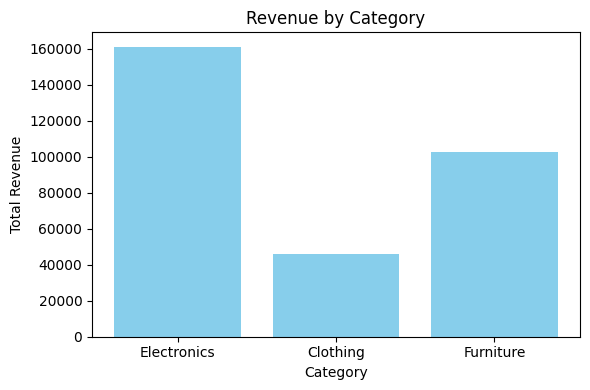

In [37]:
from pyspark.sql.functions import sum as _sum
import matplotlib.pyplot as plt
category_summary = df.groupBy("category") \
    .agg(_sum("revenue").alias("total_revenue"))

pdf = category_summary.toPandas()

plt.figure(figsize=(6, 4))
plt.bar(pdf['category'], pdf['total_revenue'], color='skyblue')
plt.xlabel("Category")
plt.ylabel("Total Revenue")
plt.title("Revenue by Category")
plt.tight_layout()
plt.show()


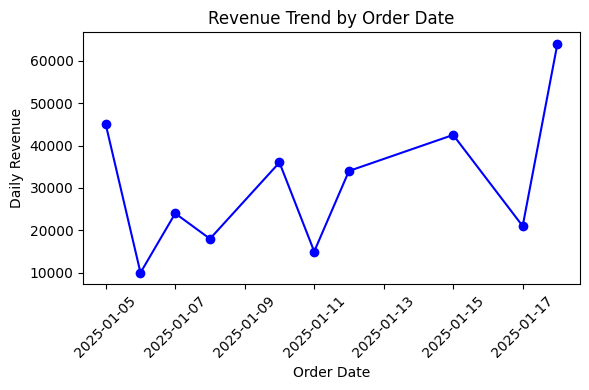

In [16]:
trend_df = df.groupBy("order_date").agg(_sum("revenue").alias("daily_revenue")).orderBy("order_date")
pdf_trend = trend_df.toPandas()
plt.figure(figsize=(6,4))
plt.plot(pdf_trend['order_date'], pdf_trend['daily_revenue'], marker='o', linestyle='-', color='blue')
plt.title("Revenue Trend by Order Date")
plt.xlabel("Order Date")
plt.ylabel("Daily Revenue")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


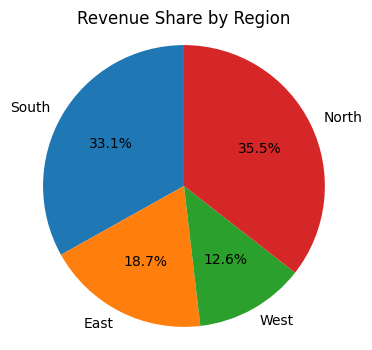

In [18]:
region_df = df.groupBy("region").agg(_sum("revenue").alias("total_revenue")).toPandas()

plt.figure(figsize=(4,4))
plt.pie(region_df["total_revenue"], labels=region_df["region"], autopct='%1.1f%%', startangle=90)
plt.title("Revenue Share by Region")
plt.axis("equal")
plt.show()


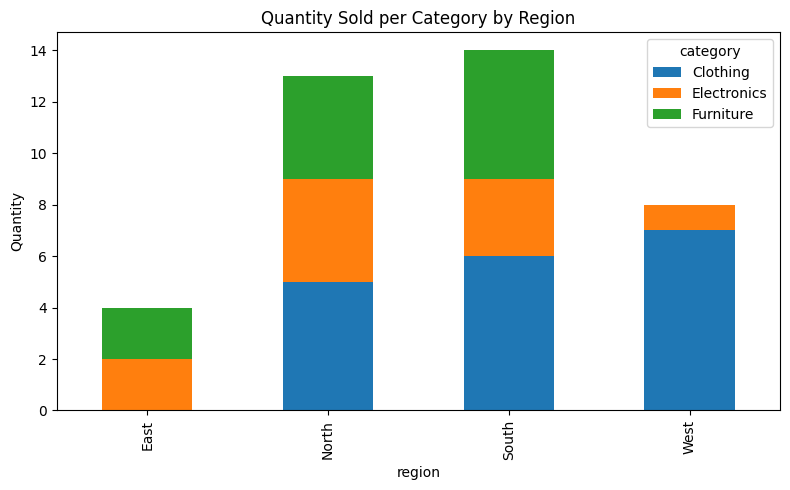

In [19]:
qty_df = df.groupBy("region", "category").agg({"quantity": "sum"}).toPandas()
pivot_qty = qty_df.pivot(index="region", columns="category", values="sum(quantity)").fillna(0)
pivot_qty.plot(kind="bar", stacked=True, figsize=(8,5))
plt.title("Quantity Sold per Category by Region")
plt.ylabel("Quantity")
plt.tight_layout()
plt.show()


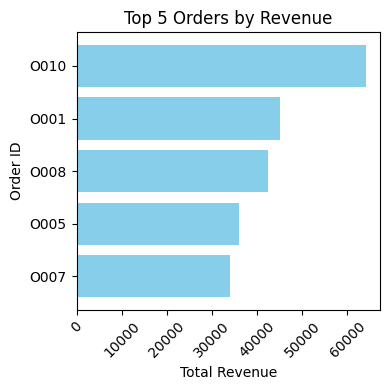

In [22]:
from pyspark.sql.functions import desc

top5_df = df.groupBy("order_id").agg(_sum("revenue").alias("total_revenue")).orderBy(desc("total_revenue")).limit(5).toPandas()

plt.figure(figsize=(4,4))
plt.barh(top5_df["order_id"], top5_df["total_revenue"], color='skyblue')
plt.xlabel("Total Revenue")
plt.ylabel("Order ID")
plt.title("Top 5 Orders by Revenue")
plt.gca().invert_yaxis()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


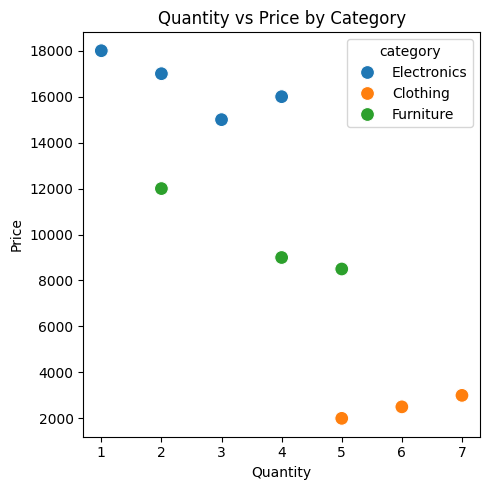

In [25]:
import seaborn as sns
pdf_scatter = df.select("quantity", "price", "category").toPandas()
plt.figure(figsize=(5,5))
sns.scatterplot(x="quantity", y="price", hue="category", data=pdf_scatter, s=100)
plt.title("Quantity vs Price by Category")
plt.xlabel("Quantity")
plt.ylabel("Price")
plt.tight_layout()
plt.show()


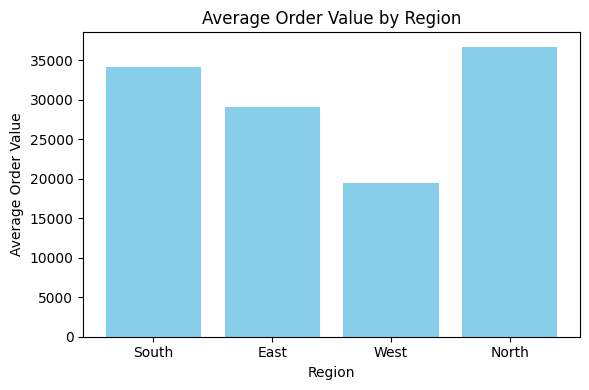

In [27]:
avg_df = df.groupBy("region").agg({"revenue": "avg"}).toPandas()
avg_df.rename(columns={"avg(revenue)": "avg_order_value"}, inplace=True)

plt.figure(figsize=(6,4))
plt.bar(avg_df['region'], avg_df['avg_order_value'], color='skyblue')
plt.title("Average Order Value by Region")
plt.ylabel("Average Order Value")
plt.xlabel("Region")
plt.tight_layout()
plt.show()


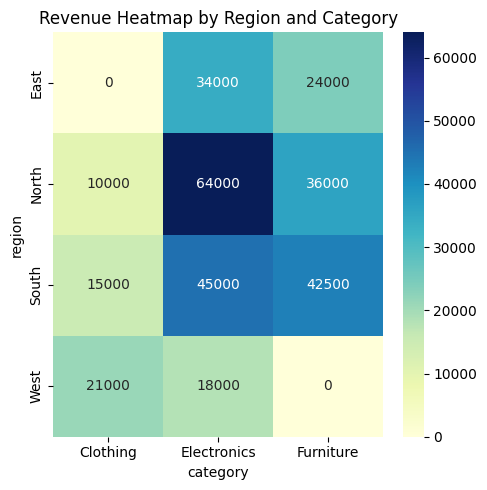

In [29]:
heat_df = df.groupBy("region", "category").agg(_sum("revenue").alias("total_revenue")).toPandas()
heat_pivot = heat_df.pivot(index="region", columns="category", values="total_revenue").fillna(0)
plt.figure(figsize=(5,5))
sns.heatmap(heat_pivot, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Revenue Heatmap by Region and Category")
plt.tight_layout()
plt.show()


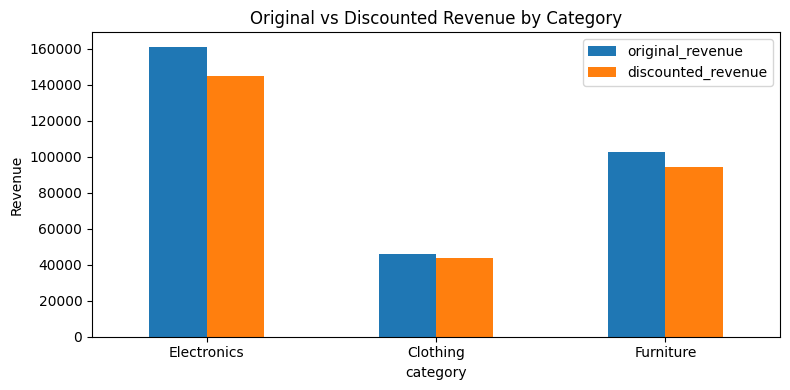

In [32]:
from pyspark.sql.functions import when, lit, col
import numpy as np
df = df.withColumn(
    "discount_rate",
    when(col("category") == "Electronics", lit(0.10))
    .when(col("category") == "Clothing", lit(0.05))
    .when(col("category") == "Furniture", lit(0.08))
    .otherwise(lit(0.0))
)

df = df.withColumn("discounted_revenue", col("revenue") * (1 - col("discount_rate")))

disc_df = df.groupBy("category").agg(
    _sum("revenue").alias("original_revenue"),
    _sum("discounted_revenue").alias("discounted_revenue")
).toPandas()

disc_df.set_index('category', inplace=True)

disc_df.plot(kind='bar', figsize=(8,4))
plt.ylabel('Revenue')
plt.title('Original vs Discounted Revenue by Category')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()